## Define Mandatory Imports, and file path for Radiogenic data

In [1]:
import os
import sys
import ROOT
import numpy as np
import matplotlib.pyplot as plt

# MUST USE THIS FILE PATH to find input radiogenic data files
filePath = "./radiogenic/05/"

# place to look for the filtered root data files
outputdir = "./scripts/output_data"
isDir = os.path.isdir(outputdir)
assert isDir, "need to have an output directory to read the filter data from!"

ROOT.gInterpreter.GenerateDictionary("ROOT::VecOps::RVec<vector<double>>", "vector;ROOT/RVec.hxx")
# ROOT.gSystem.Load("libs/build/libmyDict.so")

Welcome to JupyROOT 6.27/01


1

### helper functions to read radiogenic ROOT files

In [2]:
def getRootFiles(filePath):
    """
    this function should walk the radiogenic directory and spit back the file path
    of all ROOT files:
    """

    files = []
    for rs, ds, fs in os.walk(filePath):
        f = [f for f in fs if "root" in f]
        if f:
            f = [os.path.join(rs, f) for f in f ]
            files.extend(f)

    return files

In [3]:
def getIsotopeFiles(fs):
    """
    this function should be able to return a RDF that corresponds to the preprend
    isotope
    """
    isotopes = set()

    # file structor is: /path/to/dir/00/iso_name_file.root
    # therefore rpartition for / and then partition on _ to separate for iso
    for f in fs:
        isotope = f.rpartition("/")[2].partition("_")
        isotopes.add(isotope[0])

    # create a dictionary of isotope to files
    isotope_files = {}
    for iso in isotopes:
        isotope_files[iso] = [f for f in fs if iso in f]

    return isotope_files

In [4]:
def getRDFs(isofs):
    """
    function to create a dictionary of RDF's based on the isotope files handed to it
    """
    iso_rdfs = {}
    for isotope, files in isofs.items():
        iso_rdfs[isotope] = ROOT.RDataFrame("event_tree", files)

    return iso_rdfs

In [5]:
def defineFilters(rdfs):
    """
    function takes in rdf dictionary and should define timestamp branch ond then filter
    on data to get the interesting events, or events that have timestamps at all
    """

    for iso, rdf in rdfs.items():
        if not hasattr(ROOT, f"{iso}"):
            ROOT.gInterpreter.Declare(f"std::string {iso};")
        setattr(ROOT, f"{iso}", iso)
        rdfs[iso] = rdf.Define("Isotope", f'return {iso};')\
                       .Filter("pixel_x[0] > 0 && pixel_y[0] > 0")#\
                    #    .Filter("event == 4")

    return rdfs

In [6]:
# reads filePath from first bullet
files = getRootFiles(filePath)
print(f"found {len(files)} input ROOT Files.")

bViewMeta = False
if bViewMeta:
    # get the meta tree, pixel_size is 0.4 for all files
    metaRDF = ROOT.RDataFrame("metadata", files)
    h = metaRDF.Histo1D("pixel_size")
    h.Draw()
    ROOT.c1.Draw()

found 10 input ROOT Files.


In [7]:
isotopes = getIsotopeFiles(files)

bUpdateFiles = True
if bUpdateFiles:
    rdfs = getRDFs(isotopes)

    rdfs = defineFilters(rdfs)

    for iso, rdf in rdfs.items():
        if rdf.Count().GetValue() > 0:
            rdf.Snapshot("event_tree", f'{outputdir}/{iso}_sim.root')

In [8]:
# go MT for this data frame since we're only reading from it
ROOT.EnableImplicitMT()
files = os.listdir(outputdir)
files = [outputdir+"/"+f for f in files if ".root" in f]
drdf = ROOT.RDataFrame("event_tree", files)

### Extract and build relevant data from filter RDataFrame

In [9]:
resets = drdf.AsNumpy(["Isotope", "pixel_reset", "pixel_tslr", "pixel_x", "pixel_y"])
nResets = 0
for pr, px, py in zip(resets["pixel_reset"], resets["pixel_x"], resets["pixel_y"]):
    for r in pr:
        nResets += r.size()
print(nResets)
npResets = np.zeros(nResets)
npX = np.zeros(nResets)
npY = np.zeros(nResets)
listIso = []

## this builds the list and numpy arrays from the vector of vector structure directly
## from the RDataFrame
entry = 0
for i, (pr, px, py) in enumerate(zip(resets["pixel_reset"], resets["pixel_x"], resets["pixel_y"])):
    itr = 0
    for vr, x, y in zip(pr, px, py):
        for r in vr:
            npResets[entry] = r
            npX[entry] = x
            npY[entry] = y
            listIso.append(resets["Isotope"][i])
            entry += 1

35843


In [10]:
bViewAllResets = False
if bViewAllResets:
    plt.hist(npResets)
    ax = plt.axes(projection='3d')
    ax.scatter3D(npX, npY, npResets)

### Define Tile paramters before analysis, then find the most active tile

In [11]:
# find the most active region
xMAX = 575 # from metadata tree, 11.979 tiles in this direction..
xMIN = 1
yMAX = 1500 # from metadata tree, 31.25 tiles in this direction..
yMIN = 1
# each asic is 6x6 channels
channelXdim = 4 # 6
channelYdim = 4 # 6
# each tile is 8x8 ASIC array
arrayXdim = 10 # 8
arrayYdim = 14 # 8

# scan through the detector volume
xDIM = arrayXdim * channelXdim
yDIM = arrayYdim * channelYdim
xITR = range(xMIN, xMAX, xDIM)
yITR = range(yMIN, yMAX, yDIM)

# lots of zero positions
bestPos = 0
bestX, bestY = 0, 0
for x in xITR:
    for y in yITR:
        xpos = np.logical_and(npX>=x, npX<x+xDIM)
        ypos = np.logical_and(npY>=y, npY<y+yDIM)
        sqpos = np.logical_and(xpos, ypos)
        nResets = np.count_nonzero(sqpos)
        if nResets > bestPos:
            bestPos = nResets
            bestX = x
            bestY = y

print(f"found most active position: ({bestX},{bestY}) with {bestPos} hits")

found most active position: (281,281) with 153 hits


### all relevant data are now in npX / npY / npReset / listISO; Dump all data into a pandas dataframe

In [12]:
import pandas as pd

data = {}
data["pX"] = npX
data["pY"] = npY
data["Reset"] = npResets
data["Isotope"] = listIso

df = pd.DataFrame(data)
df["Isotope"] = df["Isotope"].map(str)

### create Asic numbers for this Tile columns using the pandas dataframe

In [13]:
from math import ceil

# count these as done in Simulation "Top Left" Asic is (0,0) : (row, col)
# create X
df['tileX'] = ((df['pX'] - 1) / xDIM).map(int)
df["AsicX"] = ((df["pX"] - 1) / channelXdim).map(int)

# create Y
df['tileY'] = ((df['pY'] - 1) / yDIM).map(int)
df["AsicY"] = ((df["pY"] - 1) / channelYdim).map(int)

# create N, unique ASIC / Tile numbers to easily histogram
df['tileN'] = df['tileX'] + df['tileY'] * ceil(xMAX / xDIM)
df['AsicN'] = df['AsicX'] + df['AsicY'] * ceil(xMAX / channelXdim)

#### Visualize total resets per tile

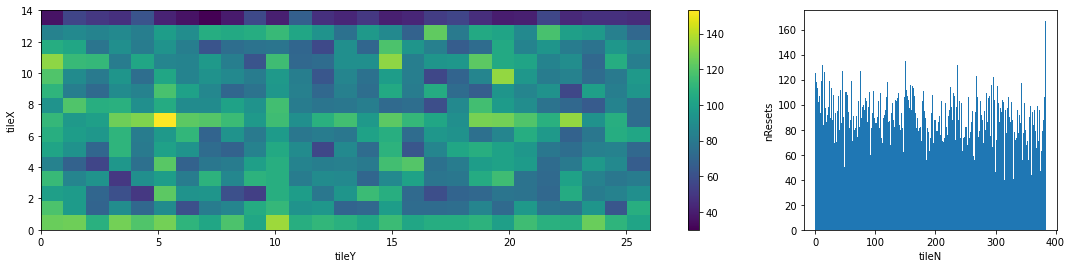

In [20]:
scale = 150
# view of tiles
x = df['tileX'].values
y = df['tileY'].values
fig, ax = plt.subplots(1, 2, figsize =(yMAX/scale*1.5, xMAX/scale), gridspec_kw={'width_ratios': [3, 1]})
h = ax[0].hist2d(y, x, bins=[len(df['tileY'].unique()), len(df['tileX'].unique())])
ax[0].set_ylabel('tileX')
ax[0].set_xlabel("tileY")
fig.colorbar(h[3], ax=ax[0])

tiles = df['tileN'].values
ax[1].hist(tiles, bins=384, range=(0,384))
ax[1].set_xlabel('tileN')
ax[1].set_ylabel('nResets')
plt.tight_layout()
plt.savefig("TileHits.png")

#### Visualize resets based on ASIC

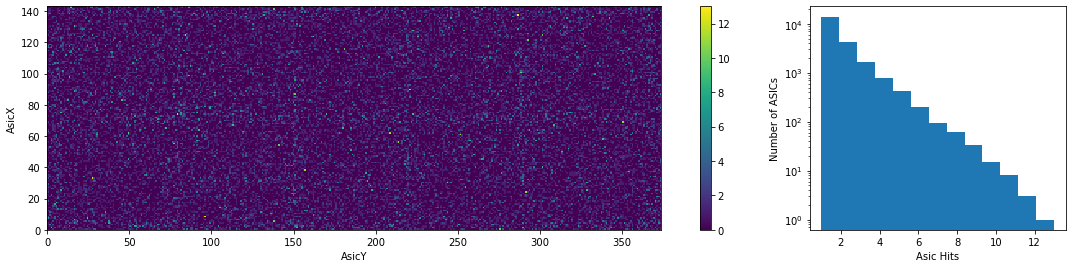

In [15]:
# view of asics
x = df['AsicX'].values
y = df['AsicY'].values

fig, ax = plt.subplots(1, 2, figsize =(yMAX/scale*1.5, xMAX/scale), gridspec_kw={'width_ratios': [3, 1]})
h = ax[0].hist2d(y, x, bins=[len(df['AsicY'].unique()), len(df['AsicX'].unique())])
ax[0].set_ylabel('AsicX')
ax[0].set_xlabel("AsicY")
fig.colorbar(h[3], ax=ax[0])

Asics = df['AsicN'].values
nAsics = len(set(df['AsicN'].unique()))
# ax[1].hist(Asics, bins=int(np.sqrt(nAsics)), range=(0,nAsics))

countAsics = df['AsicN'].value_counts()
counts = countAsics.unique()
maxCount = max(counts)
ax[1].hist(countAsics, bins=len(counts), log=True, range=(1, maxCount))
ax[1].set_ylabel("Number of ASICs")
ax[1].set_xlabel("Asic Hits")
plt.tight_layout()
plt.savefig("AsicHits.png")

### take the most active column and create a csv for its hits

Found most active tile at (x,y): (281, 281) with 153 resets.


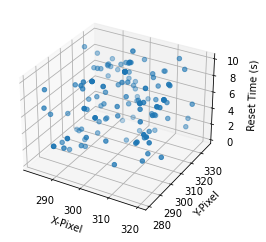

In [16]:
xmin = bestX
xmax = bestX + xDIM
ymin = bestY
ymax = bestY + yDIM

xpos = np.logical_and(npX>=xmin, npX<xmax)
ypos = np.logical_and(npY>=ymin, npY<ymax)
sqpos = np.logical_and(xpos, ypos)

bViewHits = True
if bViewHits:
    ax = plt.axes(projection='3d')
    ax.scatter3D(npX[sqpos], npY[sqpos], npResets[sqpos])
    ax.set_xlabel("X-Pixel")
    ax.set_ylabel("Y-Pixel")
    ax.set_zlabel("Reset Time (s)")
    print(f"Found most active tile at (x,y): ({bestX}, {bestY}) with {len(npX[sqpos])} resets.")

#### filter DF and store into CSV: pixel_x, pixel_y, asic_x, asic_y, reset_time

In [17]:
# Pandas filter since all of the data is here, anyways
fdf = df[ (df["pX"] >= bestX) & (df["pX"] < (bestX + xDIM)) & (df["pY"] >= bestY) & (df["pY"] < (bestY + yDIM)) ]

In [18]:
# create the tile's dataframe to send into the QPixAsicArray
tiledf = {}
tiledf["nrows"] = arrayXdim
tiledf["ncols"] = arrayYdim
tiledf["hits"] = []

# normalize asic numbers: this is for the simulation input which "0 numbers" the asic's within it's rows / cols
hitX = fdf["AsicX"].unique()
hitY = fdf["AsicY"].unique()
minX = min(hitX)
minY = min(hitY)

# build the hits tuple for each asic within the tile
for x in hitX:
    for y in hitY:
        asicResets = fdf[ (fdf["AsicX"] == x) & (fdf["AsicY"] == y) ]["Reset"].values.tolist()
        arrayX = int(x%minX)
        arrayY = int(y%minY)
        tiledf["hits"].append([arrayX, arrayY, asicResets])

# store the values within a json file
import json
outf = "/mnt/c/Users/keefe/OneDrive/Documents/qpix-digital/simulation-software/tiledf.json"
with open(outf, "w") as outputFile:
    json.dump(tiledf, outputFile, indent=4)

In [19]:
# reading in the json file
import codecs
obj_text = codecs.open(outf, 'r').read()
readDF = json.loads(obj_text)
print(readDF["hits"][:2])

[[4, 1, [4.61936705988643]], [4, 2, []]]
